In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#regression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# classification 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from pycaret.regression import *

In [168]:
# define color palette
agro = ['#b2cb91','#9bc27e','#7fa465','#668f4f','#4e6f43','#59533e','#bf9000','#ffd966','#ffe599']

In [310]:
df = pd.read_csv('Data/df_preprocessed.csv')

# outliers

### iqr

#### Repair for the regression model

In [311]:
df_iqr = df.copy()

In [312]:
# VISUALIZE OUTLIERS USING IQR

def outliers (df):
    for columns in df:
        if df[columns].dtype in ['int64', 'float64']:  

            Q1 = df[columns].quantile(0.25)
            Q3 = df[columns].quantile(0.75)
            IQR = Q3 - Q1
            max_threshold = Q3 + 1.5 * IQR
            min_threshold = Q1 - 1.5 * IQR
            outliers = df[columns][(df[columns] < min_threshold) | (df[columns] > max_threshold)]
            print("Variable " + columns + " has " + str(len(outliers)) + " outliers")

    
outliers(df_iqr)

Variable Year has 0 outliers
Variable area_harvested_ha has 10229 outliers
Variable production_tonnes has 9941 outliers
Variable yield_hg/ha has 4113 outliers
Variable avg_rainfall_mm_year has 546 outliers
Variable avg_temp_ºC has 0 outliers


Repair the outliers of each variable grouped by crops:

In [313]:
grouped_data = df_iqr.groupby('Crop')

In [314]:
def repair_outliers_group(g):
    """
    Function that applies outlier repair for each specified column using IQR 
    """
    # Repair outliers for 'area_harvested_ha'.
    Q3_area = np.quantile(g['area_harvested_ha'], 0.75)
    Q1_area = np.quantile(g['area_harvested_ha'], 0.25)
    IQR_area = Q3_area - Q1_area
    max_threshold_area = Q3_area + 1.5 * IQR_area
    min_threshold_area = Q1_area - 1.5 * IQR_area
    # Apply outlier thresholds for 'area_harvested_ha'.
    g.loc[g['area_harvested_ha'] > max_threshold_area, 'area_harvested_ha'] = max_threshold_area
    g.loc[g['area_harvested_ha'] < min_threshold_area, 'area_harvested_ha'] = min_threshold_area
    
    # Repair outliers for 'production_tonnes'.
    Q3_prod = np.quantile(g['production_tonnes'], 0.75)
    Q1_prod = np.quantile(g['production_tonnes'], 0.25)
    IQR_prod= Q3_prod - Q1_prod
    max_threshold_prod = Q3_prod + 1.5 * IQR_prod
    min_threshold_prod = Q1_prod - 1.5 * IQR_prod
    # Apply outlier thresholds for 'production_tonnes'.
    g.loc[g['production_tonnes'] > max_threshold_prod, 'production_tonnes'] = max_threshold_prod
    g.loc[g['production_tonnes'] < min_threshold_prod, 'production_tonnes'] = min_threshold_prod
    
    # Repair outliers for 'production_tonnes'.
    Q3_y = np.quantile(g['yield_hg/ha'], 0.75)
    Q1_y = np.quantile(g['yield_hg/ha'], 0.25)
    IQR_y= Q3_y - Q1_y
    max_threshold_y = Q3_y + 1.5 * IQR_y
    min_threshold_y = Q1_y - 1.5 * IQR_y
    # Apply outlier thresholds for 'yield_hg/ha'.
    g.loc[g['yield_hg/ha'] > max_threshold_y, 'yield_hg/ha'] = max_threshold_y
    g.loc[g['yield_hg/ha'] < min_threshold_y, 'yield_hg/ha'] = min_threshold_y
    
    return g

# Apply the function to the df
df_iqr = grouped_data.apply(repair_outliers_group).reset_index(drop=True)

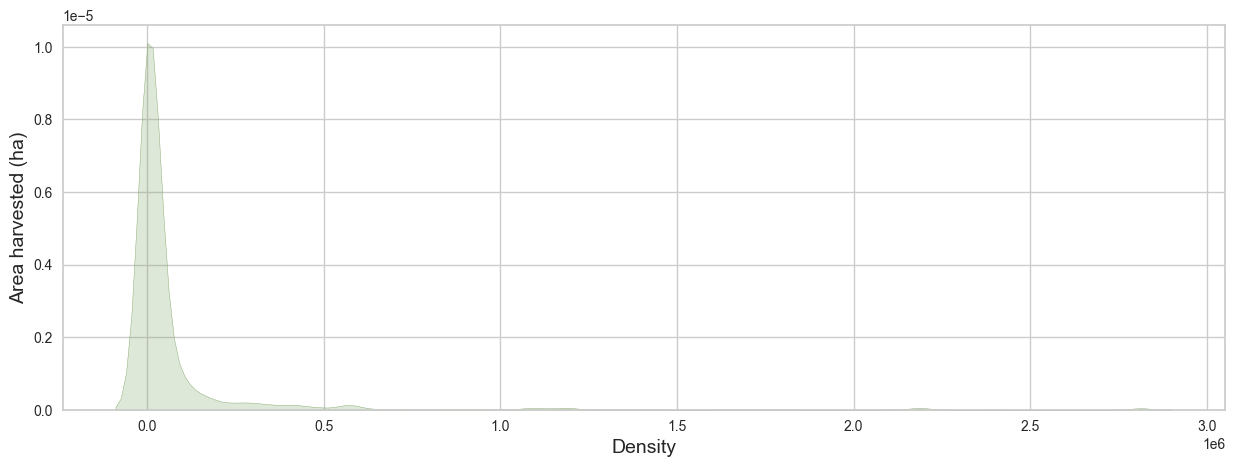

In [315]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_iqr, x='area_harvested_ha', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Area harvested (ha)', fontsize=14)
plt.show()

In [199]:
# Save clean csv:
df_iqr.to_csv('Data/df_clean_regression.csv', index=False)

#### Repair for the classification model

In [316]:
# Use of repaired df_iqr + repair precipitation column
df_iqr_c = df_iqr.copy()

In [317]:
#In this case we are grouping by Area
grouped_data = df_iqr_c.groupby('Area')

In [319]:
def repair_outliers_group(g):
    """
    Function that applies outlier repair for each specified column using IQR 
    """
    # Repair outliers for 'avg_rainfall_mm_year'.
    Q3_rain = np.quantile(g['avg_rainfall_mm_year'], 0.75)
    Q1_rain = np.quantile(g['avg_rainfall_mm_year'], 0.25)
    IQR_rain = Q3_rain - Q1_rain
    max_threshold_rain = Q3_rain + 1.5 * IQR_rain
    min_threshold_rain = Q1_rain - 1.5 * IQR_rain
    # Apply outlier thresholds for 'avg_rainfall_mm_year'.
    g.loc[g['avg_rainfall_mm_year'] > max_threshold_rain, 'avg_rainfall_mm_year'] = max_threshold_rain
    g.loc[g['avg_rainfall_mm_year'] < min_threshold_rain, 'avg_rainfall_mm_year'] = min_threshold_rain
    
    return g

# Apply the function to the df
df_iqr_c = grouped_data.apply(repair_outliers_group).reset_index(drop=True)

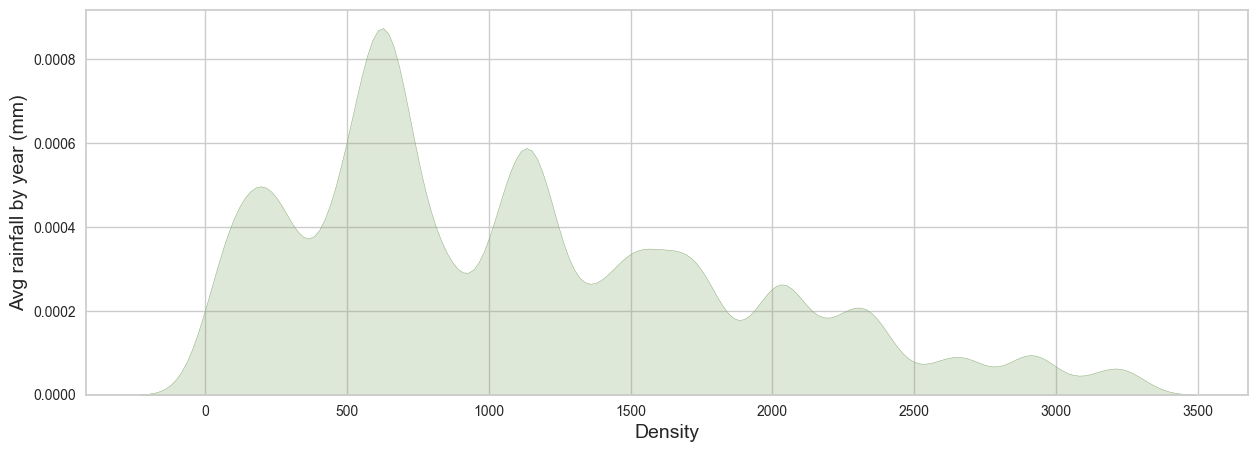

In [322]:
# kernel density estimate (KDE) plot
plt.figure(figsize=(15, 5))
ax = sns.kdeplot(data=df_iqr_c, x='avg_rainfall_mm_year', fill=True, color=agro[2])
ax.set_xlabel('Density', fontsize=14)
ax.set_ylabel('Avg rainfall by year (mm)', fontsize=14)
plt.show()

In [330]:
# Save clean csv:
df_iqr_c.to_csv('Data/df_clean_classification.csv', index=False)

# modelling

## correlation analysis

In [213]:
df_enc = df.copy()

In [214]:
# encoder con diccionarios
# # read JSON file with countries list
with open('json/countries_final.json', 'r') as f:
    countries = json.load(f)
# read JSON file with crop list
with open('json/crops.json', 'r') as f:
    crops = json.load(f)
    
# Crear un diccionario de mapeo
mapeo_area = {country: indice for indice, country in enumerate(countries)} # guardar json
mapeo_crop = {crop: indice for indice, crop in enumerate(crops)} # guardar json

# Reemplazar los barrios con números utilizando el diccionario de mapeo
df_enc.loc[:,'Area'] = df_enc['Area'].replace(mapeo_area)
df_enc.loc[:,'Crop'] = df_enc['Crop'].replace(mapeo_crop)

# Guarda el diccionario de mapeo como un archivo JSON
with open('json/encoder_area.json', 'w') as archivo:
    json.dump(mapeo_area, archivo)
with open('json/encoder_crop.json', 'w') as archivo:
    json.dump(mapeo_crop, archivo)

In [215]:
# Spearman's method 
corr = df_enc.corr(method='spearman')

In [216]:
# Analysis of variables highly correlated 

threshold = 0.1
corr[(corr>threshold)|(corr<-threshold)]

,Area,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha,avg_rainfall_mm_year,avg_temp_ºC
Area,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crop,NaN,1.000000,NaN,-0.226962,-0.207637,NaN,0.131079,0.132035
Year,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
area_harvested_ha,NaN,-0.226962,NaN,1.000000,0.881703,-0.173426,NaN,NaN
production_tonnes,NaN,-0.207637,NaN,0.881703,1.000000,0.250760,-0.102721,-0.120568
yield_hg/ha,NaN,NaN,NaN,-0.173426,0.250760,1.000000,NaN,-0.125208
avg_rainfall_mm_year,NaN,0.131079,NaN,NaN,-0.102721,NaN,1.000000,0.244488
avg_temp_ºC,NaN,0.132035,NaN,NaN,-0.120568,-0.125208,0.244488,1.000000


## Regression modelling and model evaluation

- Encoder df_regression

In [1]:
# create a df with the variables that have a high correlation with the target variable (yield) + target var  + Crop
df_regression = df_iqr[['Crop','area_harvested_ha','production_tonnes',
		 'avg_temp_ºC',
		 'yield_hg/ha']]

NameError: name 'df_iqr' is not defined

In [218]:
#Save csv
df_regression.to_csv('Data/df_ml_regression.csv', index=False)

In [254]:
# Replace the crops with numbers using the mapping dictionary
df_regression.loc[:,'Crop'] = df_regression['Crop'].replace(mapeo_crop)

- Data split

In [203]:
# assign the independent variables and the dependent variable. Our target variable is yield
X = df_regression.drop(['yield_hg/ha'], axis=1)
y = df_regression['yield_hg/ha']

In [204]:
# split the data into training set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=357) 

In [205]:
# Normalisation

#Initiating the scaler
scaler = StandardScaler()
 
#Normalise training variables
X_train_scaled = scaler.fit_transform(X_train)
 
#We apply the same normalisation to the test 
X_test_scaled = scaler.transform(X_test)

In [206]:
# save scaler
joblib.dump(scaler, 'scaler_regr.pkl')

['scaler_regr.pkl']

Traning models:

- ElasticNet

In [184]:
from sklearn.metrics import mean_squared_error as mse

In [207]:
#Initialise model and parameters
alpha = 0.1 
l1_ratio = 0.1 
#instance the model
model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 0)
#train model
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse_ElasticNet = mse(y_test, y_pred)
mse_ElasticNet**.5

159315.5267998634

- Stochastic Gradient Descent

In [208]:
#Initialise model and parameters
penalty = 'elasticnet' 
alpha = .1 
l1_ratio = .1 
#instance the model
model = SGDRegressor(penalty = penalty, alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 0)
#train model
model.fit(X_train_scaled, y_train)
mse_SGDRegressor = mse(y_test,model.predict(X_test_scaled))
print(mse_SGDRegressor**.5)

159197.9472162881


- Random Forest

In [209]:
#Initialise model and parameters
n_estimators = 200 
criterion = 'squared_error' 
max_depth = None 
min_samples_split = 2 
verbose = 1 
#instance the model
model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, verbose=verbose)
#train model
model.fit(X_train_scaled, y_train)
mse_RF = mse(y_test,model.predict(X_test_scaled))
print(mse_RF**.5)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   26.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


16914.546389610845


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.0s


- Boosting: *Gradient Descent*

In [211]:
#Initialise model and parameters
params = {"booster":"gbtree", "max_depth": 2, "eta": 0.3, "objective": "reg:squarederror", "nthread":2}
num_boost_round = 10
#convert the data to DMatrix format.
train_data = xgb.DMatrix(X_train_scaled, label=y_train)
test_data = xgb.DMatrix(X_test_scaled, label=y_test)
##instance the model and train model
model = xgb.train(params = params, dtrain = train_data, num_boost_round=num_boost_round)
mse_XGB = mse(y_test,model.predict(test_data))
print(mse_XGB**0.5)

123035.85451898641


Compare models:

Text(0.5, 0, 'Model')

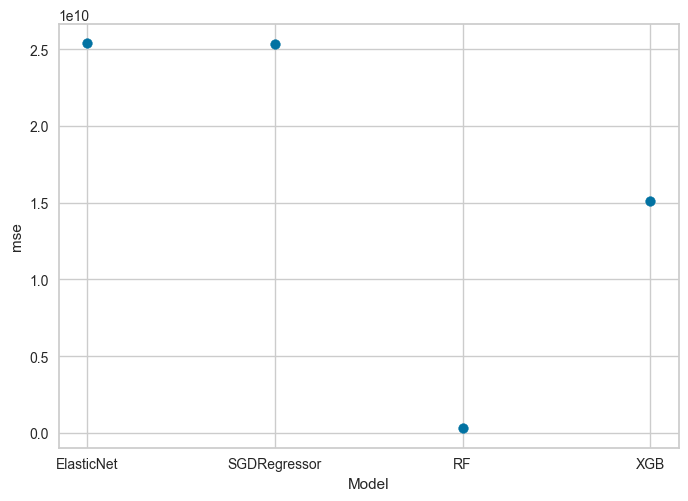

In [212]:
mse = [mse_ElasticNet, mse_SGDRegressor, mse_RF, mse_XGB] 
plt.scatter(['ElasticNet', 'SGDRegressor', 'RF', 'XGB'], mse) 
plt.ylabel('mse')
plt.xlabel('Model')

Best Model: Random Forest

In [210]:
#save best model

joblib.dump(model, 'models/yield_RF.pkl') 

['models/yield_RF.pkl']

---
### Fast Machine Learning (Pycaret)

In [36]:
df = pd.read_csv('Data/df_ml_regression.csv')

In [37]:
#Set the target: yield
setup = setup(data = df, target = 'yield_hg/ha', session_id = 357)	

,Description,Value
0,Session id,357
1,Target,yield_hg/ha
2,Target type,Regression
3,Original data shape,"(62994, 4)"
4,Transformed data shape,"(62994, 4)"
5,Transformed train set shape,"(44095, 4)"
6,Transformed test set shape,"(18899, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


In [38]:
# compare models and choose the best
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:03:22
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,4166.2087,948014410.0786,30697.9579,0.9612,0.1051,0.0307,6.4730
et,Extra Trees Regressor,4309.7725,960885255.9972,30824.3185,0.9607,0.1342,0.0476,3.4430
xgboost,Extreme Gradient Boosting,9497.7277,1014968812.8000,31735.9510,0.9583,0.2641,0.1456,0.1970
lightgbm,Light Gradient Boosting Machine,11362.6446,1262634577.5066,35449.0380,0.9483,0.3042,0.2361,0.2760
dt,Decision Tree Regressor,6412.1133,1591864998.7079,39598.1572,0.9345,0.1226,0.0480,0.1410
knn,K Neighbors Regressor,16535.0730,4179539020.8000,64603.4820,0.8285,0.2837,0.1890,0.0520
gbr,Gradient Boosting Regressor,29239.9353,4201029000.5752,64737.0481,0.8279,0.5672,0.5848,2.2470
llar,Lasso Least Angle Regression,105851.2109,23138914508.8000,152063.8000,0.0505,1.4217,4.4513,0.0230
lar,Least Angle Regression,105851.2102,23138915123.2000,152063.8016,0.0505,1.4217,4.4513,0.0240
en,Elastic Net,105854.4781,23138926592.0000,152063.8516,0.0505,1.4222,4.4527,0.0680


RF is also the best model by PyCaret

## Classification modelling and model evaluation

- Encoder df_classification

In [331]:
# create a df for the classification model --> target: crop
df_classification = df_iqr_c[['Area','area_harvested_ha',
		 'avg_rainfall_mm_year',
		 'avg_temp_ºC','Crop']]

In [332]:
#Save csv
df_classification.to_csv('Data/df_ml_classification.csv', index=False)

In [333]:
# Replace the countries with numbers using the mapping dictionary
df_classification.loc[:,'Area'] = df_classification['Area'].replace(mapeo_area)

- Data split

In [334]:
# assign the independent variables and the dependent variable. Our target variable is Crop
X = df_classification.drop(['Crop'], axis=1)
y = df_classification['Crop']

# split the data into training set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = .25, random_state=7)

In [335]:
# Normalisation

#Initiating the scaler
scaler = StandardScaler()
 
#Normalise training variables
X_train_scaled = scaler.fit_transform(X_train)
 
#We apply the same normalisation to the test 
X_test_scaled = scaler.transform(X_test)

In [336]:
# save scaler
joblib.dump(scaler, 'scaler_classif.pkl')

['scaler_classif.pkl']

Traning models:

- Logistic model

In [339]:
# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(max_iter =1000) # Si aumentamos a 10k, se quita el warning. Si queremos usar un modelo potente, usar Colab
#Entrenamos en los datos
logreg.fit(X_train_scaled, y_train)  
#Predecimos
y_pred = logreg.predict(X_test_scaled)
# Classification report
print(classification_report(y_test, y_pred, zero_division=1))

                                                              precision    recall  f1-score   support

                                                      Apples       0.05      0.05      0.05       278
                                                     Bananas       0.12      0.04      0.05       338
                                                      Barley       0.14      0.15      0.15       307
                                                  Beans, dry       1.00      0.00      0.00       346
                                                    Cabbages       0.04      0.23      0.07       428
                                Cantaloupes and other melons       1.00      0.00      0.00       271
                                         Carrots and turnips       0.06      0.01      0.02       374
                                              Cassava, fresh       0.05      0.05      0.05       266
                                   Cauliflowers and broccoli       1.00      0.00

- KNN regression

In [338]:
#Parameters
weights = 'distance'
p = 2
n_neighbours = 5
#Model
clf = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                                                              precision    recall  f1-score   support

                                                      Apples       0.61      0.61      0.61       278
                                                     Bananas       0.65      0.66      0.65       338
                                                      Barley       0.72      0.67      0.69       307
                                                  Beans, dry       0.58      0.53      0.55       346
                                                    Cabbages       0.47      0.52      0.50       428
                                Cantaloupes and other melons       0.45      0.45      0.45       271
                                         Carrots and turnips       0.48      0.49      0.48       374
                                              Cassava, fresh       0.61      0.65      0.63       266
                                   Cauliflowers and broccoli       0.46      0.48

- Random Forest

In [337]:
RFC = RandomForestClassifier()
RFC.fit(X_train_scaled, y_train)
y_preds = RFC.predict(X_test_scaled)
print(classification_report(y_test, y_preds))

                                                              precision    recall  f1-score   support

                                                      Apples       0.59      0.57      0.58       278
                                                     Bananas       0.65      0.65      0.65       338
                                                      Barley       0.70      0.66      0.68       307
                                                  Beans, dry       0.56      0.53      0.55       346
                                                    Cabbages       0.48      0.47      0.48       428
                                Cantaloupes and other melons       0.46      0.44      0.45       271
                                         Carrots and turnips       0.49      0.47      0.48       374
                                              Cassava, fresh       0.59      0.64      0.61       266
                                   Cauliflowers and broccoli       0.48      0.45

In [340]:
#save best model

joblib.dump(RFC, 'models/crop_RF.pkl') 

['models/crop_RF.pkl']

---

In [ ]:
# Crear un diccionario de mapeo inverso
mapeo_area = {country: indice for indice, country in enumerate(countries)} # guardar json
mapeo_crop = {crop: indice for indice, crop in enumerate(crops)} # guardar json

mapeo_inverso_area = {indice: country for country, indice in mapeo_area.items()}
df_enc.loc[:,'Area'] = df_enc['Area'].replace(mapeo_inverso_area)

mapeo_inverso_crop = {indice: crop for crop, indice in mapeo_crop.items()}
df_enc.loc[:,'Crop'] = df_enc['Crop'].replace(mapeo_inverso_crop)

# Guarda el diccionario de mapeo como un archivo JSON
with open('json/decoder_area.json', 'w') as archivo:
    json.dump(mapeo_inverso_area, archivo)
with open('json/decoder_crop.json', 'w') as archivo:
    json.dump(mapeo_inverso_crop, archivo)